In [1]:
import pandas as pd
import folium
from geopy import distance
import matplotlib.pyplot as plt
import seaborn as sns
import descartes
import geopandas as gpd
import libpysal
from shapely.geometry import Point, Polygon
from libpysal import weights, examples
from libpysal.cg import voronoi_frames
from contextily import add_basemap
import networkx as nx
import numpy as np
import logging
import requests_cache
import requests
import json
from math import radians, cos, sin, asin, sqrt

In [2]:
df = pd.read_csv(r"C:\Users\marco\Downloads\Electric_Vehicle_Charging_Stations_in_New_York (1).csv")

In [3]:
df['Year'] = df['Open Date'].str[6:]
df = df.drop(['Fuel Type Code', 'Intersection Directions','Station Phone','Status Code','Owner Type Code',
         'Federal Agency ID','Federal Agency Name','Cards Accepted',
         'EV Network Web','ZIP','Groups With Access Code','Expected Date','Access Days Time',
         'Geocode Status','Updated At','Plus4','Date Last Confirmed',"EV Other Info","Open Date"], axis=1)

In [4]:
df.head()

,Station Name,Street Address,City,State,EV Level1 EVSE Num,EV Level2 EVSE Num,EV DC Fast Count,EV_Network,Latitude,Longitude,ID,EV Connector Types,Year
0,St. George Courthouse,54 Central Ave,Staten Island,NY,NaN,5.0,NaN,EV Connect,40.639469,-74.076912,65296,J1772,2016
1,RRH RIEDMAN CAMP10,100 Kings Hwy S,Rochester,NY,NaN,2.0,NaN,ChargePoint Network,43.201826,-77.574561,121386,J1772,2019
2,Avon,74 Genesee Street,Avon,NY,NaN,2.0,NaN,EV Connect,42.910944,-77.746320,123132,J1772,2019
3,SKIDMORE SUSSMAN,Lower Scribner Village Rd,Saratoga Springs,NY,NaN,2.0,NaN,ChargePoint Network,43.098653,-73.789220,123552,J1772,2019
4,WARRENCOUNTY DPW 2,1344 U.S. 9,Lake George,NY,NaN,2.0,NaN,ChargePoint Network,43.359015,-73.701099,150258,J1772,2019


In [5]:
lista = ['New York',"Bronx","Brooklyn","Queens","Staten Island",
         "Manhattan","Borough Park","Washington Heights","New York City",
        "Astoria","Jamaica","JAMAICA","Jackson Heights",]
esclusione = ["Geneva on the Lake Resort", "ABELENORTHSIDE STATION 1","Buy Low Flooring / Queen of Harts Pizza"]
Network = ["Tesla","Tesla Destination","ChargePoint Network","Blink Network"]

In [6]:
NYC_df = df.query("City in @lista")

In [7]:
NYC_df = NYC_df.query("City not in @esclusione")

In [8]:
dict(NYC_df["EV_Network"].value_counts())

{'Tesla Destination': 307,
 'ChargePoint Network': 72,
 'Blink Network': 46,
 'FLO': 38,
 'LIVINGSTON': 31,
 'EV Connect': 23,
 'Tesla': 12,
 'Volta': 8,
 'Non-Networked': 7,
 'AMPUP': 6,
 'SemaCharge Network': 3,
 'Electrify America': 2,
 'eVgo Network': 1,
 'EVGATEWAY': 1,
 'CHARGELAB': 1,
 'SHELL_RECHARGE': 1}

In [9]:
dict(NYC_df["City"].value_counts())

{'New York': 350,
 'Brooklyn': 96,
 'Staten Island': 30,
 'Manhattan': 18,
 'Bronx': 17,
 'Queens': 15,
 'Borough Park': 10,
 'Jamaica': 8,
 'Astoria': 6,
 'Jackson Heights': 3,
 'New York City': 3,
 'JAMAICA': 2,
 'Washington Heights': 1}

In [10]:
NYC_df.shape

(559, 13)

In [11]:
NYC_df = NYC_df.query("EV_Network in @Network")

I 4 maggiori Network di ricarica appartengono a Tesla, Livingstone e EV Connect, e non sono compresi in nessun network specifico. Con questi 4 otteniamo circa il 78% della rete. Per semplicità terremo solo le stazioni che fanno parte dei 3 network principali.

Vengono eliminate le colonne che non presentano dati utili all'analisi o che presentano dei NaN in ogni osservazione.

In [12]:
NYC_df.index.names = ['Index']
NYC_df = NYC_df.fillna(value=0)
NYC_df.shape

(437, 13)

Il dataset presenta 437 osservazioni, solo relative alla città di New York. 

In [13]:
NYC_df =NYC_df.reset_index(drop=True)

In [14]:
NYC_df

,Station Name,Street Address,City,State,EV Level1 EVSE Num,EV Level2 EVSE Num,EV DC Fast Count,EV_Network,Latitude,Longitude,ID,EV Connector Types,Year
0,CORP COMM 3 STATION 8 CC3,Teleport Dr/Corp Commons Bldg,Staten Island,NY,0.0,2.0,0.0,ChargePoint Network,40.604324,-74.179675,252136,J1772,2023
1,PANYNJ JFK Y GARAGE 5,JFK Access Road JFK International Airport,Queens,NY,0.0,2.0,0.0,ChargePoint Network,40.645916,-73.779152,174642,J1772,2021
2,Tribeca Green,325 North End Ave,New York,NY,0.0,2.0,0.0,Blink Network,40.716950,-74.014948,164713,J1772,2020
3,NYC FLEET DPRWFMARINA#3,109-5 Marina Rd,Queens,NY,0.0,1.0,0.0,ChargePoint Network,40.760424,-73.856316,193126,J1772,2021
4,HAMPTON INN STATION 1,1120 South Ave,Staten Island,NY,0.0,2.0,0.0,ChargePoint Network,40.612696,-74.179012,168146,J1772,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...
432,CORP COMM 3 STATION 3 CC3,Teleport Dr/Corp Commons Bldg,Staten Island,NY,0.0,2.0,0.0,ChargePoint Network,40.604086,-74.179358,252135,J1772,2023
433,Icon Parking 322 23rd Street - Tesla Destination,318-322 E 23rd St,New York,NY,0.0,3.0,0.0,Tesla Destination,40.737533,-73.980437,115092,J1772 TESLA,2018
434,MPG 923 5th Ave - Tesla Destination,923 5th Ave,New York,NY,0.0,3.0,0.0,Tesla Destination,40.773004,-73.966152,115196,J1772 TESLA,2017
435,Icon Parking E 48th Street - Tesla Destination,329 E 48th St,New York,NY,0.0,3.0,0.0,Tesla Destination,40.753079,-73.968032,115097,J1772 TESLA,2015


In [15]:
# NYC_df["Next Latitude"],NYC_df["Next Longitude"] = "",""

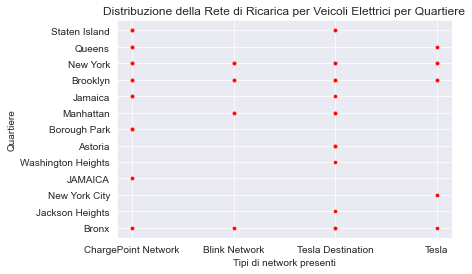

In [16]:
sns.set_style('darkgrid')
sns.scatterplot(x='EV_Network', y='City', data=NYC_df, s=15, color='red')
# Imposta il titolo e le etichette degli assi
plt.title("Distribuzione della Rete di Ricarica per Veicoli Elettrici per Quartiere")
plt.xlabel("Tipi di network presenti")
plt.ylabel("Quartiere")

# Mostra il grafico
plt.show()


Plot della mappa

In [17]:
location = NYC_df[["Latitude", "Longitude", "Station Name","EV_Network","ID"]]

# Calculate the center of the map based on the mean of Latitude and Longitude values
mean_latitude = location['Latitude'].mean()
mean_longitude = location['Longitude'].mean()
maps = folium.Map(location=[mean_latitude, mean_longitude], zoom_start=10, control_scale=True)

location.apply(lambda x: folium.Marker([x["Latitude"], x["Longitude"]], popup=x["Station Name"]).add_to(maps), axis=1)
maps

Calcolo distanza e tempo di guida da una colonnina alla successiva

In [18]:
# NYC_df["Distance"] = ""
NYC_df["Duration"]=""

Calcolo della distanza tramite Open Street Map

In [19]:
NYC_df["EV_Network"].value_counts()

Tesla Destination      307
ChargePoint Network     72
Blink Network           46
Tesla                   12
Name: EV_Network, dtype: int64

In [20]:
# API_key = '96dd7cb32a8d43a1b8c78d219b21d381'
# url = 'http://router.project-osrm.org/route/v1/driving/'

In [21]:
# def getDistances(row):
#     o1 = str(row['Longitude']) +',' + str(row['Latitude'])
#     o2 = str(row['Next Longitude']) + ',' + str(row['Next Latitude']) 
#     x = o1 + ';' + o2
    
#     response = requests.get(url+x)
#     data = json.loads(response.content)
    
#     if response.status_code == 200:
#         return data['routes'][0]['distance']/1000 #in km
#     else:
#         return 0

In [22]:
# def getDuration(row):
#     o1 = str(row['Longitude']) +',' + str(row['Latitude'])
#     o2 = str(row['Next Longitude']) + ',' + str(row['Next Latitude']) 
#     x = o1 + ';' + o2
    
#     response = requests.get(url+x)
#     data = json.loads(response.content)
    
#     if response.status_code == 200:
#         return data['routes'][0]['duration']/60 #in min
#     else:
#         return 0

In [23]:
def haversine(lat1, lon1, lat2, lon2):
    # Converte le coordinate in radianti
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # Calcola la differenza di longitudine e latitudine
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    # Applica la formula di Haversine
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * asin(sqrt(a))
    r = 6371  # Raggio della Terra in km
    return c * r

def distance_matrix(df):
    # Calcola la matrice delle distanze geodetiche tra tutte le coppie di coordinate
    matrix = []
    for i in range(len(df)):
        row = []
        for j in range(len(df)):
            if i == j:
                row.append(0)
            else:
                dist = haversine(df.iloc[i]['Latitude'], df.iloc[i]['Longitude'], 
                                 df.iloc[j]['Latitude'], df.iloc[j]['Longitude'])
                row.append(dist)
        matrix.append(row)
    
    # Converte la matrice in un DataFrame
    df_matrix = pd.DataFrame(matrix, index=df.index, columns=df.index)
    
    return df_matrix

dist_matrix = distance_matrix(NYC_df)
dist_matrix.mean().mean()

7.991967311484924

In [25]:
dist_matrix.quantile(0.25).mean()

4.637496443434907

In [26]:
dist_matrix.quantile(0.75).mean()

9.560582978614773

In [27]:
nonzero_vals = dist_matrix[dist_matrix != 0]
min_val = nonzero_vals.min()
print(min_val.min())

0.00040419376058315495


In [28]:
dist_matrix.max().max()

55.18962365272874

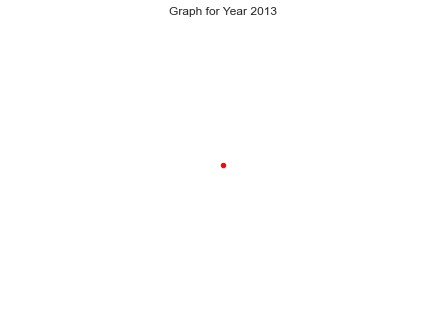

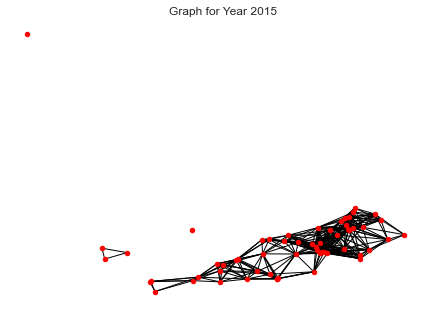

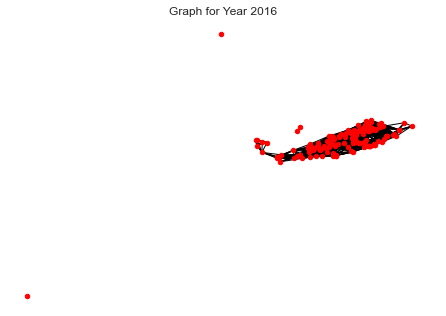

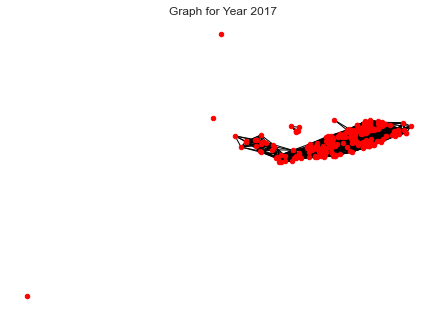

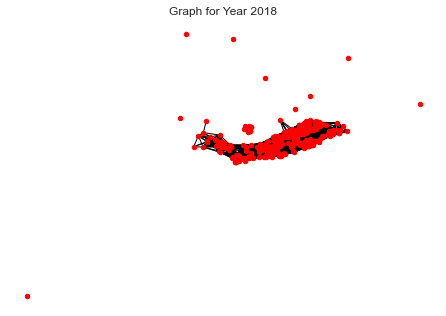

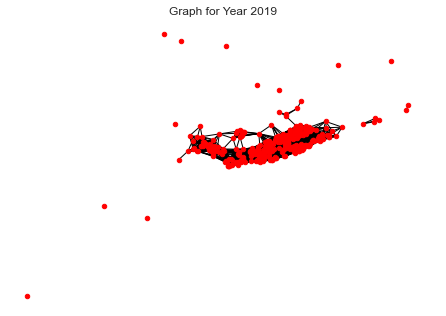

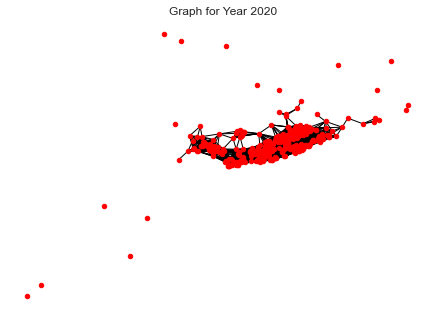

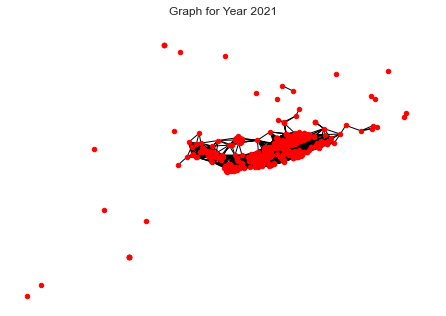

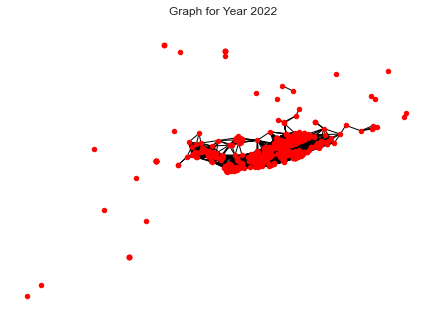

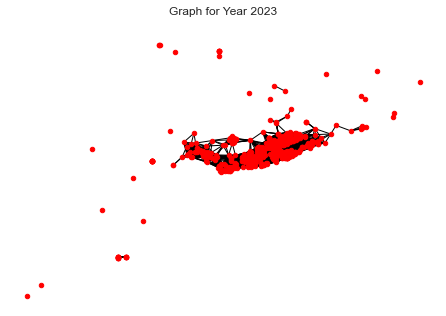

In [29]:
import networkx as nx
import pandas as pd
from haversine import haversine

def create_graphs(df):
    # Group dataframe by year
    df_grouped = df.groupby('Year')

    # Create a graph for each year with only values up to that year
    for year, df_year in df_grouped:
        # Filter dataframe to only include rows up to the current year
        df_filtered = df[df['Year'] <= year]

        # Initialize graph
        G = nx.Graph()

        # Add nodes to graph
        for i, row in df_filtered.iterrows():
            G.add_node(i, pos=(row['Latitude'], row['Longitude']))

        # Add edges to graph
        for i, row1 in df_filtered.iterrows():
            for j, row2 in df_filtered.loc[row1.name+1:].iterrows():
                p1 = row1[['Latitude', 'Longitude']].to_numpy()
                p2 = row2[['Latitude', 'Longitude']].to_numpy()
                dist = haversine(p1, p2)
                if dist <= 2:
                    G.add_edge(i, j)

        # Yield graph for current year
        yield year, G
        
        
graphs = create_graphs(NYC_df)

# Iterate over the graphs for each year
for year, G in graphs:
    pos = nx.get_node_attributes(G, 'pos')
    nx.draw(G, pos=pos, with_labels=False, node_size=20, node_color="red")
    plt.title(f"Graph for Year {year}")
    plt.show()


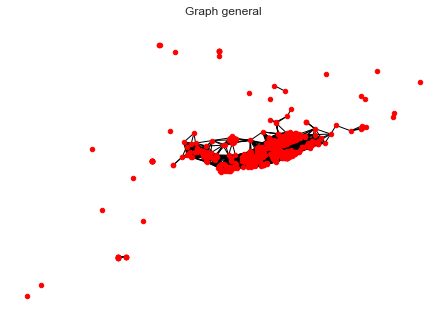

In [30]:
def create_graph(df):
    # Initialize graph
    G = nx.Graph()

    # Add nodes to graph
    for i, row in df.iterrows():
        G.add_node(i, pos=(row['Latitude'], row['Longitude']))

    # Add edges to graph
    for i, row1 in df.iterrows():
        for j, row2 in df.loc[row1.name+1:].iterrows():
            p1 = row1[['Latitude', 'Longitude']].to_numpy()
            p2 = row2[['Latitude', 'Longitude']].to_numpy()
            dist = haversine(p1, p2)
            if dist <= 2:
                G.add_edge(i, j)

    return G

G = create_graph(NYC_df)

# Draw graph
pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos=pos, with_labels=False, node_size=20, node_color="red")
plt.title("Graph general")
plt.show()

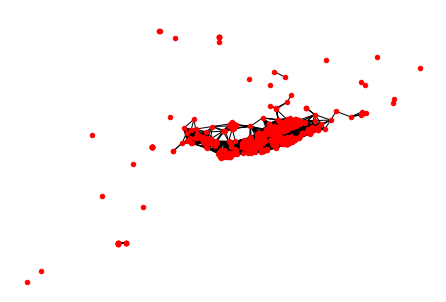

In [31]:
G = create_graph(NYC_df)

# Draw and show the graph
pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos, with_labels=False, node_size=20, node_color="red")
plt.show()

Le distanze tra le colonnine vanno dai circa 0.5km ad un massimo di circa 57km, con una media attorno ai 9km.
Per quanto riguarda il tempo tra una colonnina e l'altro si passa da un minimo di 1 minuto agli oltre 56, con una media di circa 13 minuti e mezzo tra una e l'altra. Qui stiamo prendendo in esame tutte le stazioni, non solo quelle relative ai network Tesla, Livingston ed EV Connect.

In questo modo abbiamo ottenuto la distanza (in miglia) tra una colonnina e la successiva

In [32]:
values=["Tesla","Tesla Destination"]
tesla_df = NYC_df[NYC_df.EV_Network.isin(values)]
cpn_df = NYC_df[NYC_df['EV_Network'] =="ChargePoint Network"]
bn_df = NYC_df[NYC_df['EV_Network'] =="Blink Network"]

Divido il dataset in 4 (uno per ogni network) in modo da poter confrontare i pattern di posizionamento.

In [33]:
tesla_df.shape

(319, 14)

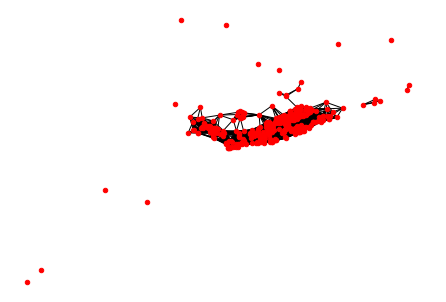

In [34]:
G = create_graph(tesla_df)

pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos, with_labels=False, node_size=20, node_color="red")
plt.show()

In [35]:
closeness = nx.closeness_centrality(G)
mean_closeness = np.mean(list(closeness.values()))

print("Media closeness centrality Tesla:", mean_closeness)

Media closeness centrality Tesla: 0.28756431681498323


In [36]:
betweenness = nx.betweenness_centrality(G)
mean_betweennes = np.mean(list(betweenness.values()))

print("Media betweennes centrality Tesla:", mean_betweennes)

Media betweennes centrality Tesla: 0.006424270536217895


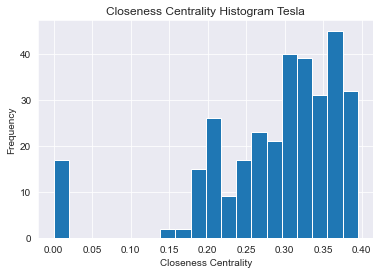

In [37]:
plt.hist(list(closeness.values()), bins=20)
plt.title("Closeness Centrality Histogram Tesla")
plt.xlabel("Closeness Centrality")
plt.ylabel("Frequency")
plt.show()

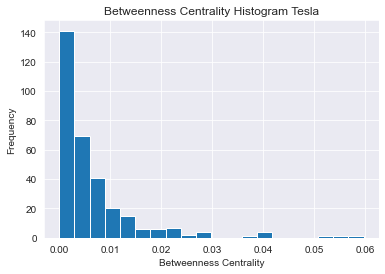

In [38]:
plt.hist(list(betweenness.values()), bins=20)
plt.title("Betweenness Centrality Histogram Tesla")
plt.xlabel("Betweenness Centrality")
plt.ylabel("Frequency")
plt.show()

In [39]:
cpn_df.shape

(72, 14)

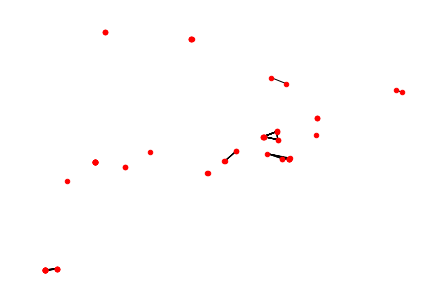

In [40]:
G = create_graph(cpn_df)

pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos, with_labels=False, node_size=20, node_color="red")
plt.show()

In [41]:
closeness = nx.closeness_centrality(G)
mean_closeness = np.mean(list(closeness.values()))
print("Media closeness centrality Charge Point Network:", mean_closeness)

Media closeness centrality Charge Point Network: 0.107981220657277


In [42]:
betweenness = nx.betweenness_centrality(G)
mean_betweennes = np.mean(list(betweenness.values()))

print("Media betweennes centrality Charge Point Network:", mean_betweennes)

Media betweennes centrality Charge Point Network: 0.0


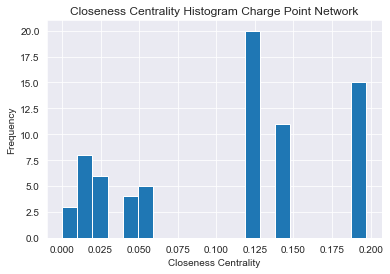

In [43]:
plt.hist(list(closeness.values()), bins=20)
plt.title("Closeness Centrality Histogram Charge Point Network")
plt.xlabel("Closeness Centrality")
plt.ylabel("Frequency")
plt.show()

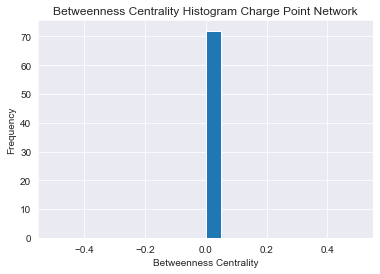

In [44]:
plt.hist(list(betweenness.values()), bins=20)
plt.title("Betweenness Centrality Histogram Charge Point Network")
plt.xlabel("Betweenness Centrality")
plt.ylabel("Frequency")
plt.show()

In [45]:
bn_df.shape

(46, 14)

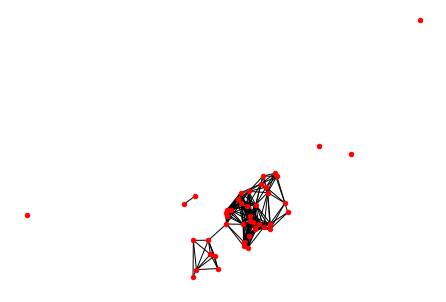

In [46]:
G = create_graph(bn_df)

pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos, with_labels=False, node_size=20, node_color="red")
plt.show()

In [47]:
closeness = nx.closeness_centrality(G)
mean_closeness = np.mean(list(closeness.values()))
print("Media closeness centrality Blink Network:", mean_closeness)

Media closeness centrality Blink Network: 0.3257925805423297


In [48]:
betweenness = nx.betweenness_centrality(G)
mean_betweennes = np.mean(list(betweenness.values()))

print("Media betweennes centrality Blink Network:", mean_betweennes)

Media betweennes centrality Blink Network: 0.025076855511638123


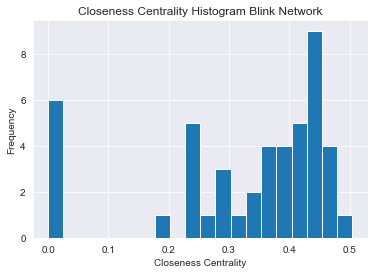

In [49]:
plt.hist(list(closeness.values()), bins=20)
plt.title("Closeness Centrality Histogram Blink Network")
plt.xlabel("Closeness Centrality")
plt.ylabel("Frequency")
plt.show()

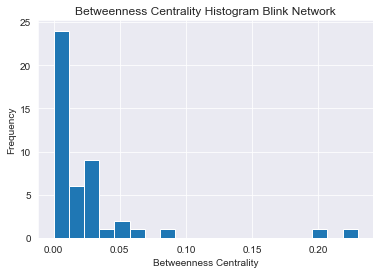

In [50]:
plt.hist(list(betweenness.values()), bins=20)
plt.title("Betweenness Centrality Histogram Blink Network")
plt.xlabel("Betweenness Centrality")
plt.ylabel("Frequency")
plt.show()